# Capstone Project 1 Machine Learning

With Capstone Project 1 the intent is to predict if a borrower is likely to default on their loan and have their loan charged off.  

This is a typical Classification model for Data Science as our information can be broken down into two groups, charged off (default) or fully paid. Having some inference to understand what inputs affect the prediction would be helpful, but the bottom line is understanding if borrowers will end up in default or not.   

In previous sections the data was cleaned, explored, and statistical analysis was run.  Now it is time to make predictions with Machine Learning.

### Load the libraries and set display options

In [1]:
!pip install catboost

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from datetime import datetime
from scipy.stats import t
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV, RidgeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer, scale
from sklearn.svm import SVC

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

## Read in the Dataset

In [4]:
df = pd.read_csv('Data/Loan_Storied.csv',low_memory=False,index_col=0, 
                parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 
                               'debt_settlement_flag_date', 'settlement_date','sec_app_earliest_cr_line'])

C:\Users\Scott\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Take a quick look at the dataframe to make sure it looks like what we were expecting

In [5]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate_pct,installment,grade,sub_grade,emp_title,emp_length_years,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util_pct,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,meets_credit_policy
0,5000.000,5000.000,4975.000,36.000,0.106,162.870,B,B2,NaN,10.000,RENT,24000.000,Verified,2011-12-01,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.650,0.000,1985-01-01,1.000,nan,nan,3.000,0.000,13648.000,0.837,9.000,f,0.000,0.000,5863.155,5833.840,5000.000,863.160,0.000,0.000,0.000,2015-01-01,171.620,NaT,2019-05-01,0.000,nan,1.000,Individual,nan,nan,NaN,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan,nan,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,N,NaT,NaN,NaT,nan,nan,nan,True
1,2500.000,2500.000,2500.000,60.000,0.153,59.830,C,C4,Ryder,0.500,RENT,30000.000,Source Verified,2011-12-01,Charged Off,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.000,0.000,1999-04-01,5.000,nan,nan,3.000,0.000,1687.000,0.094,4.000,f,0.000,0.000,1014.530,1014.530,456.460,435.170,0.000,122.900,1.110,2013-04-01,119.660,NaT,2016-10-01,0.000,nan,1.000,Individual,nan,nan,NaN,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan,nan,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,N,NaT,NaN,NaT,nan,nan,nan,True
2,2400.000,2400.000,2400.000,36.000,0.160,84.330,C,C5,NaN,10.000,RENT,12252.000,Not Verified,2011-12-01,Fully Paid,n,NaN,small_business,real estate business,606xx,

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422722 entries, 0 to 1422721
Columns: 142 entries, loan_amnt to meets_credit_policy
dtypes: bool(1), datetime64[ns](8), float64(108), object(25)
memory usage: 1.5+ GB


## Get rid of columns that don't apply

We need to get rid of columns that contain information that happens after a loan has been given out, such as hardships.  This is really an important step and it also helps us downsize our dataset a little bit.  

In [7]:
drop_list = ['collection_recovery_fee', 'debt_settlement_flag','debt_settlement_flag_date','deferral_term','delinq_amnt','hardship_amount','hardship_dpd', 'hardship_end_date', 'hardship_flag','hardship_last_payment_amount','hardship_length', 'hardship_loan_status','hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'last_pymnt_amnt','last_pymnt_d','next_pymnt_d','orig_projected_additional_accrued_interest','out_prncp','out_prncp_inv','payment_plan_start_date','pymnt_plan','recoveries','settlement_amount','settlement_date','settlement_percentage','settlement_status','settlement_term','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp','desc','zip_code','title','emp_title','meets_credit_policy']
df = df.drop(drop_list, axis=1)

# Perform some pre-processing on the data

### Change the dates to floats by subtracting to or from the issue date

In [8]:
df['issue_d_minus_earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days
df['last_credit_pull_d_minus_issue_d'] = (df['last_credit_pull_d']-df['issue_d']).dt.days
df['issue_d_minus_sec_app_earliest_cr_line'] = (df['issue_d']-df['sec_app_earliest_cr_line']).dt.days

### That allows us to drop the date fields

In [9]:
dt_drop_list = ['issue_d','earliest_cr_line','last_credit_pull_d','sec_app_earliest_cr_line']
df = df.drop(dt_drop_list, axis=1)

### Convert Default to Charged Off since it is the same outcome 

In [10]:
df['loan_status'] = np.where(df['loan_status'] == 'Default','Charged Off',df['loan_status'])
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

### Get rid of null values

In [11]:
# This will show us how many null values we have in each column
# That will tell us exactly which columns need to be cleaned-up
df.isnull().sum()

loan_amnt                                       0
funded_amnt                                     0
funded_amnt_inv                                 0
term_months                                     0
int_rate_pct                                    0
installment                                     0
grade                                           0
sub_grade                                       0
emp_length_years                            84136
home_ownership                                  0
annual_inc                                      4
verification_status                             0
loan_status                                     0
purpose                                         0
addr_state                                      0
dti                                           461
delinq_2yrs                                    29
inq_last_6mths                                 30
mths_since_last_delinq                     717293
mths_since_last_record                    1180462


### Use the imputer to fill values on Object type data with the most appropriate value

We only have one column with object type data, verification status for joint account.  For rows that do not have a value it makes the most sense to fill them in with Not Verified.  

In [12]:
imp_con = SimpleImputer(strategy='constant',fill_value='Not Verified')

In [13]:
df.loc[:,'verification_status_joint'] = imp_con.fit_transform(df.loc[:,'verification_status_joint'].to_numpy().reshape(-1,1))

### Use the imputer to fill columns with numeric values using the average of the value in the column

In [14]:
imp_mean = SimpleImputer()

In [15]:
df.loc[:,'emp_length_years'] = imp_mean.fit_transform(df.loc[:,'emp_length_years'].to_numpy().reshape(-1,1))

In [16]:
df.loc[:,'annual_inc'] = imp_mean.fit_transform(df.loc[:,'annual_inc'].to_numpy().reshape(-1,1))

In [17]:
df.iloc[:,15:25] = imp_mean.fit_transform(df.iloc[:,15:25])

In [18]:
df.iloc[:,26:28] = imp_mean.fit_transform(df.iloc[:,26:28])

In [19]:
df.iloc[:,30:32] = imp_mean.fit_transform(df.iloc[:,30:32])

In [20]:
df.iloc[:,33:100] = imp_mean.fit_transform(df.iloc[:,33:100])

### Check that all of the null values are gone

In [21]:
df.isnull().values.sum()

0

### Let's use a Heatmap and see if we can get rid of correlated data

Here we are creating a quick function that will create a heatmap. This heat map will show correlation between columns. 

In [22]:
def heatMap(df, mirror=False):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(100, 100))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

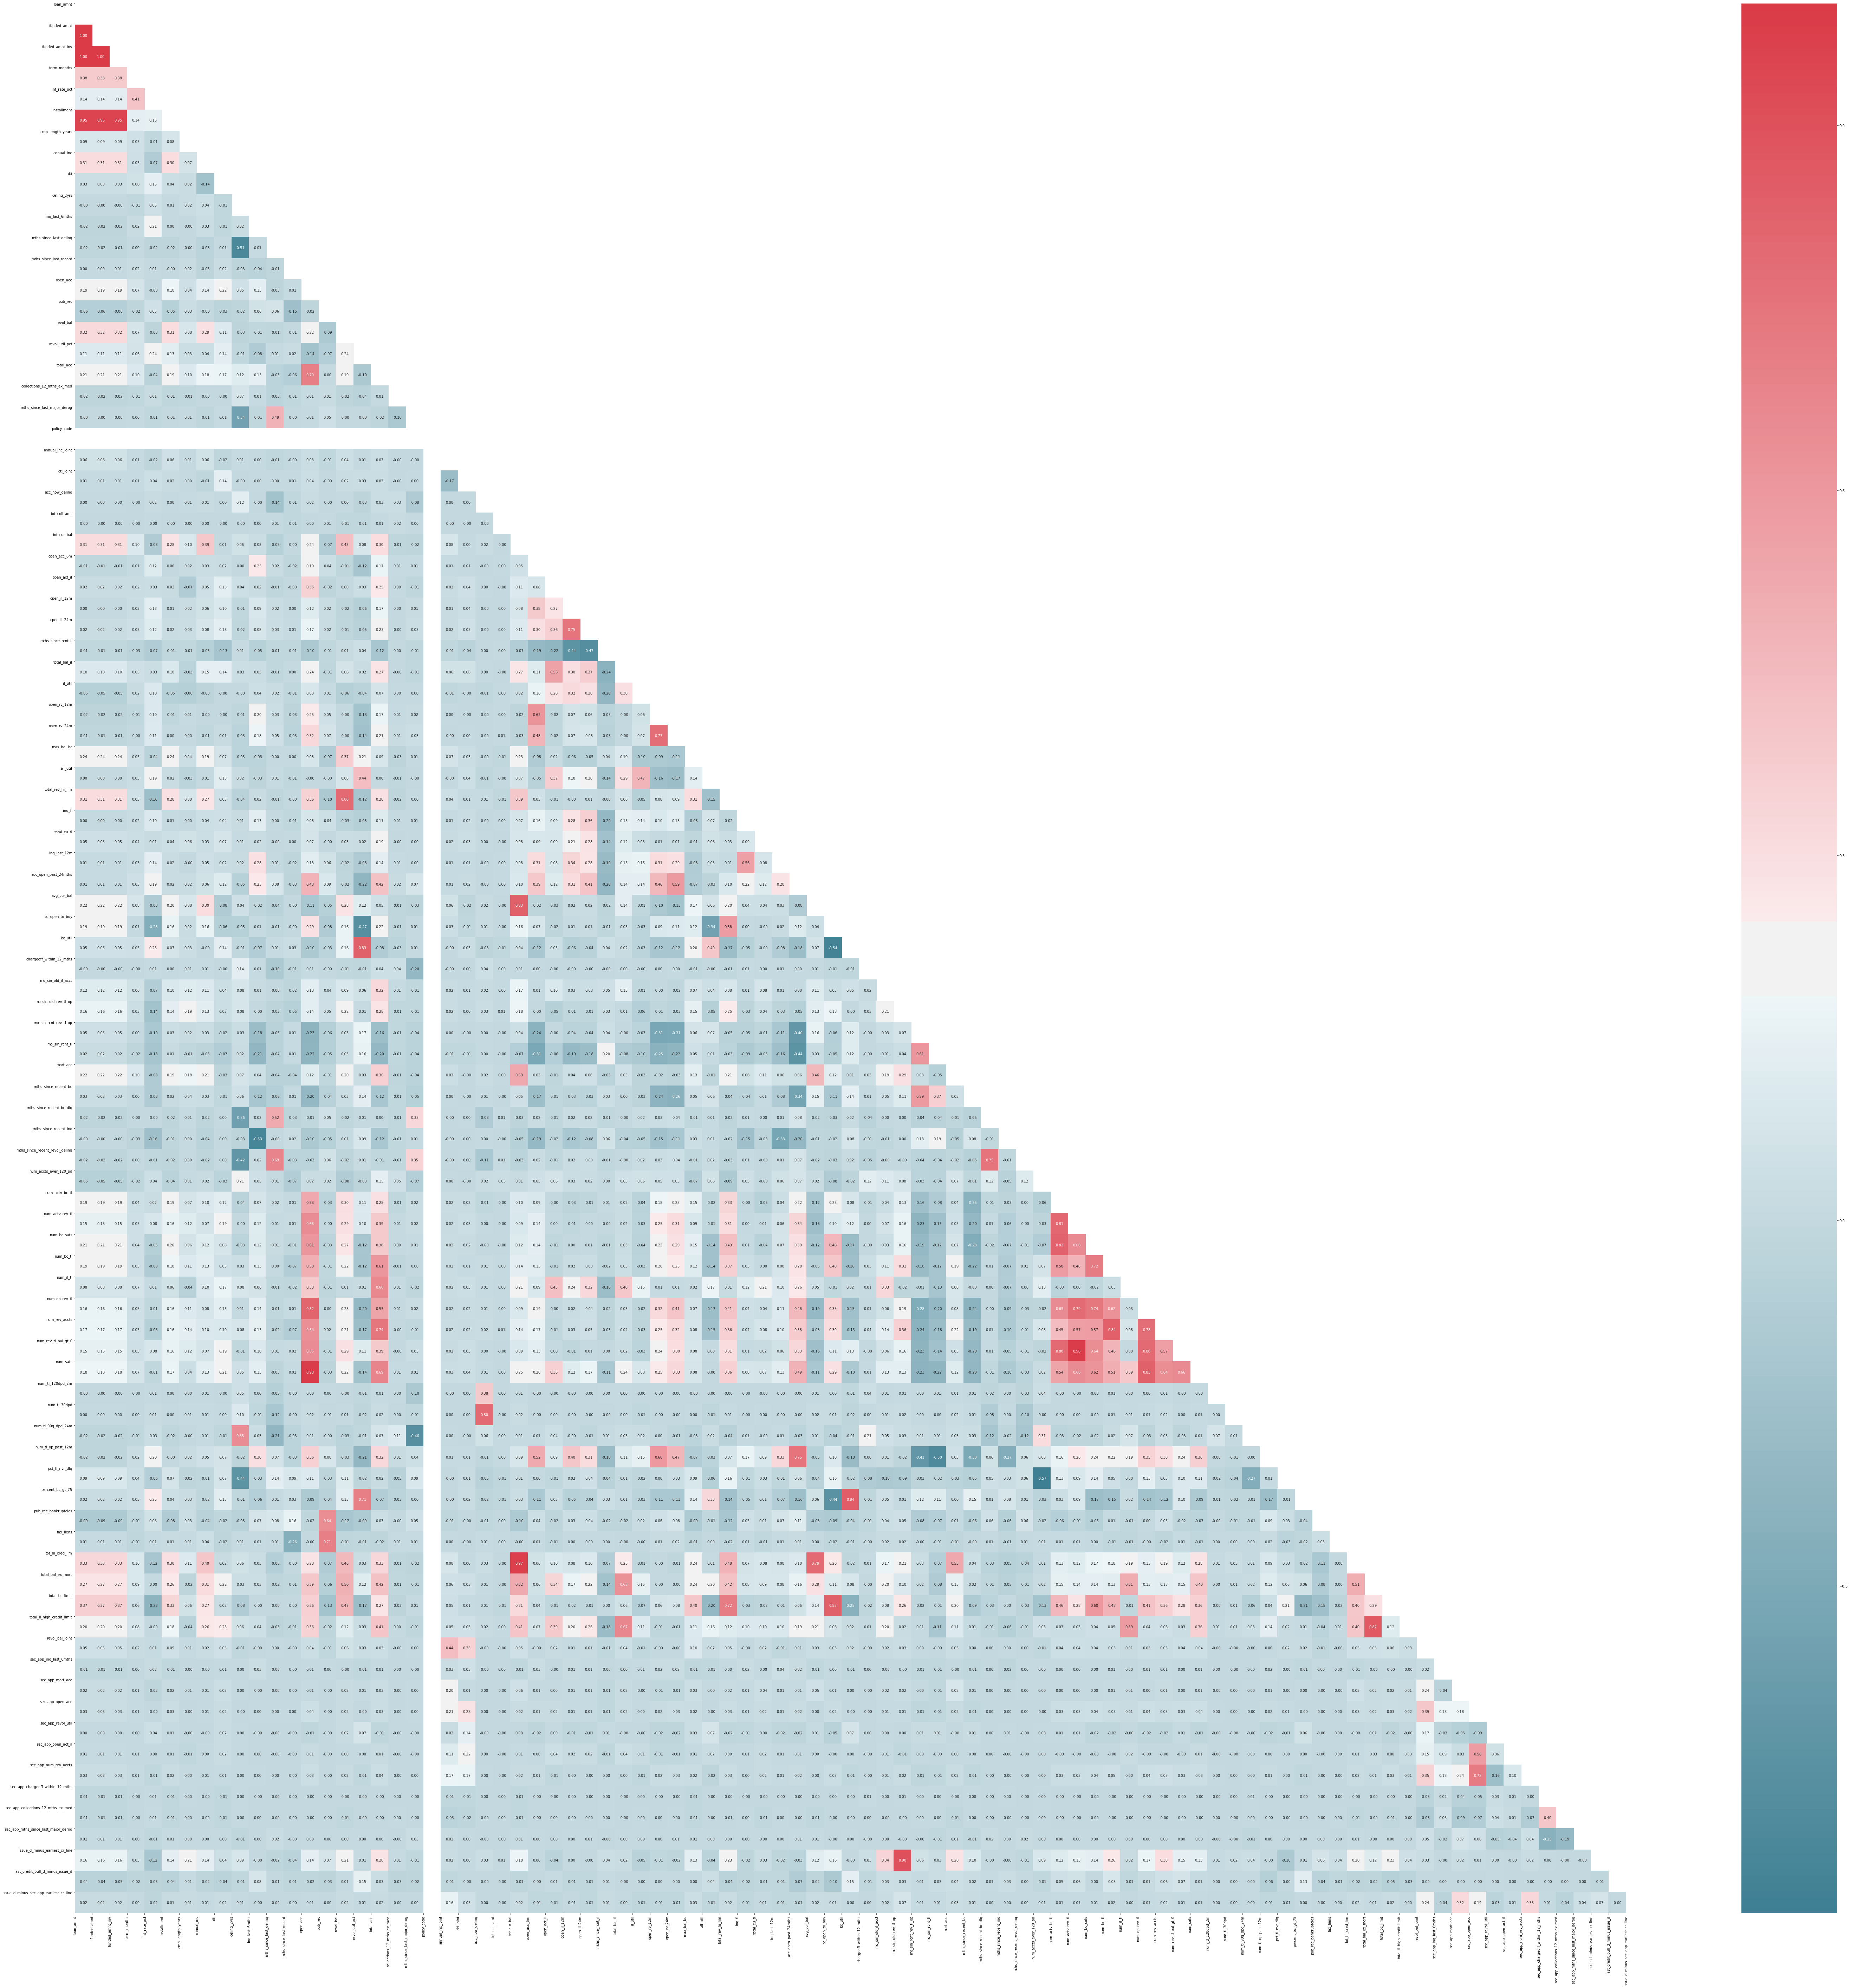

In [23]:
heatMap(df)

### For every column pair that is at or over 90% correlated we will drop one of the columns

In [24]:
corr_drop_list = ['funded_amnt','funded_amnt_inv','installment','open_acc','tot_cur_bal','total_bal_il','num_rev_tl_bal_gt_0','mo_sin_old_rev_tl_op']
df = df.drop(corr_drop_list, axis=1)

### Print one more heatmap to check our work

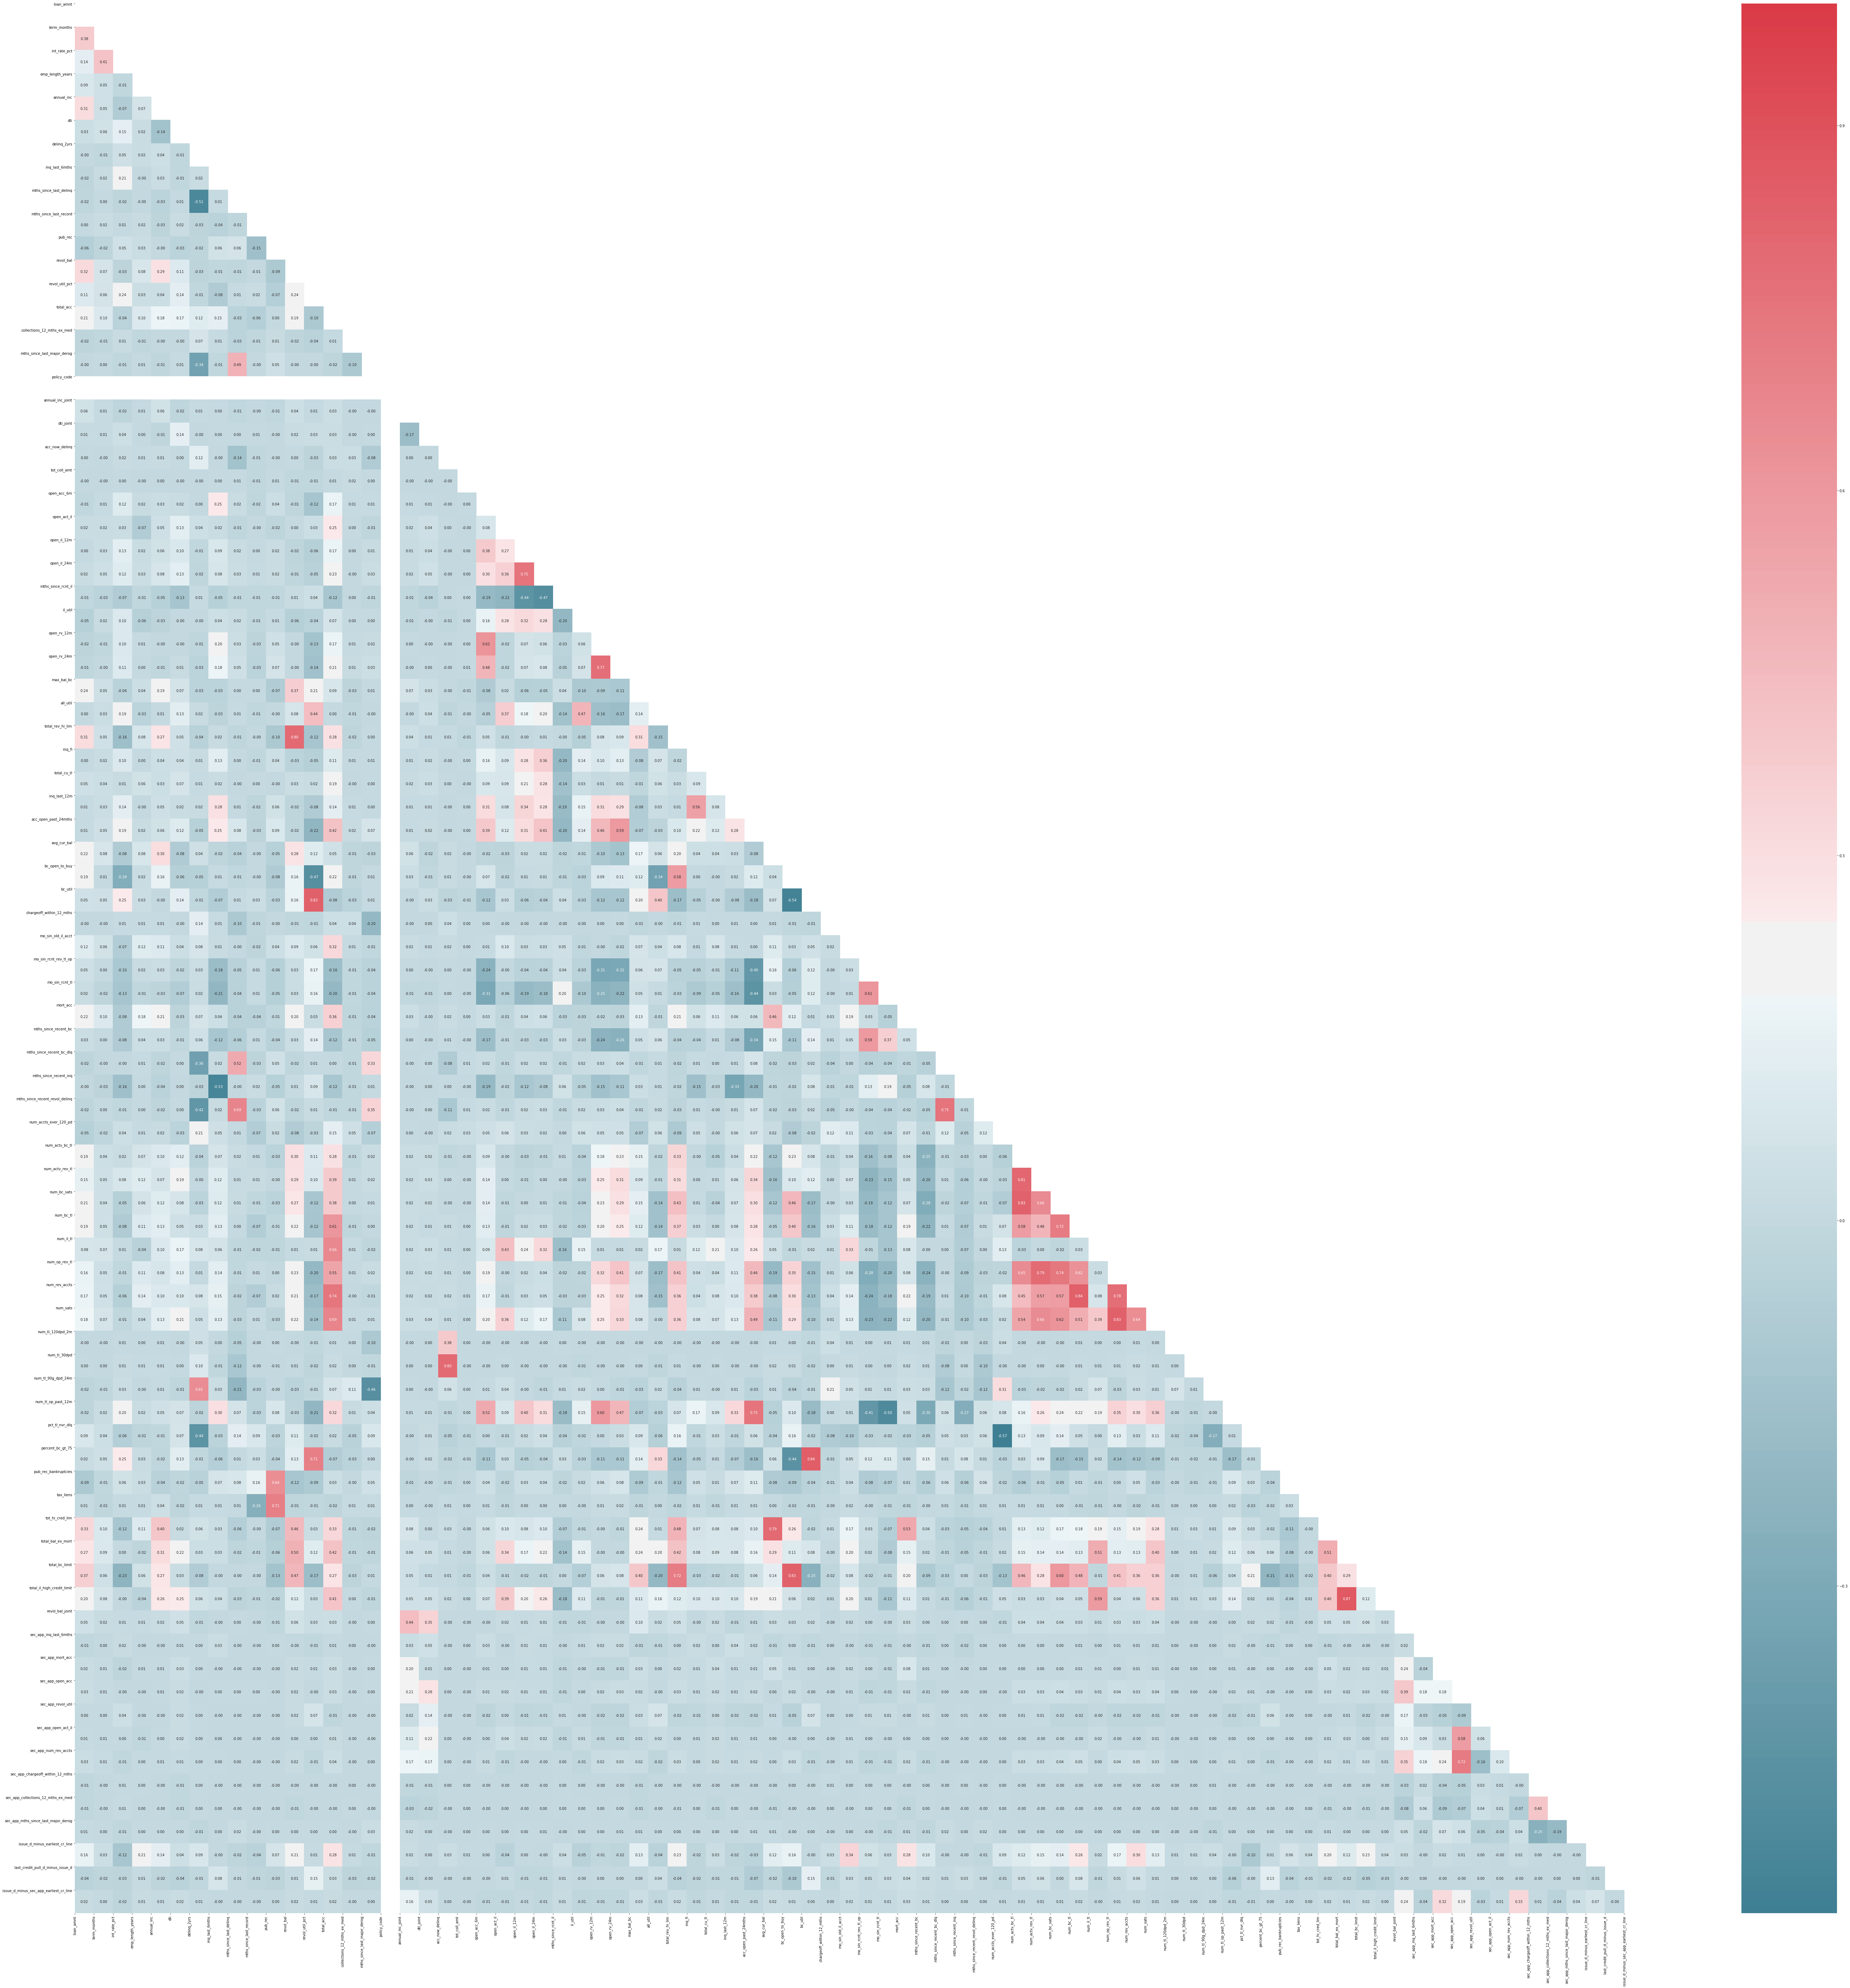

In [25]:
heatMap(df)

## These are the object datatype variables that will need to be changed to numeric variables.  

Machine learning techniques, in general, can only handle numeric values.  We need to replace object data types with numeric data types.  

In [26]:
obj_list = sorted(list(df.select_dtypes(include=['object']).columns))
for i in range(len(obj_list)):
    print('column name:  ',obj_list[i])
    print('number of unique values:  ',len(df[obj_list[i]].unique()))
    print('unique values:  ')
    print(df[obj_list[i]].unique())
    print("--------------------------")

column name:   addr_state
number of unique values:   51
unique values:  
['AZ' 'GA' 'IL' 'CA' 'OR' 'NC' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA'
 'MN' 'NJ' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'CO' 'KS' 'NV'
 'AK' 'MD' 'WV' 'VT' 'MI' 'DC' 'SD' 'NH' 'AR' 'NM' 'MT' 'HI' 'WY' 'OK'
 'DE' 'MS' 'TN' 'IA' 'NE' 'ID' 'IN' 'ME' 'ND']
--------------------------
column name:   application_type
number of unique values:   2
unique values:  
['Individual' 'Joint App']
--------------------------
column name:   grade
number of unique values:   7
unique values:  
['B' 'C' 'A' 'E' 'F' 'D' 'G']
--------------------------
column name:   home_ownership
number of unique values:   6
unique values:  
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
--------------------------
column name:   initial_list_status
number of unique values:   2
unique values:  
['f' 'w']
--------------------------
column name:   loan_status
number of unique values:   2
unique values:  
['Fully Paid' 'Charged Off']
--------------

In [27]:
# Pandas get_dummies does all of the heavy lifting for creating numeric columns and removing the object columns
df = pd.get_dummies(df, prefix_sep='_', drop_first=True)

In [28]:
# Verify that the data is all float or unsigned integers
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422722 entries, 0 to 1422721
Columns: 197 entries, loan_amnt to verification_status_joint_Verified
dtypes: float64(82), uint8(115)
memory usage: 1.0 GB


# I am putting in a write and read so I don't have to keep going back to the beginning if I need to restart the Kernel

In [29]:
#df.to_csv('Data/Loan_preproc.csv')

In [30]:
#df = pd.read_csv('Data/Loan_preproc.csv',low_memory=False,index_col=0)

## Split the dataset into X and y datasets

In [31]:
# We pull the data from the dataframe for our target values as y
df_y = df['loan_status_Fully Paid']
df_y.head()

0    1
1    0
2    1
3    1
4    1
Name: loan_status_Fully Paid, dtype: uint8

In [32]:
# Convert to numpy array and check the shape
y = df_y.to_numpy() #reshape(-1,1)???
y.shape

(1422722,)

In [33]:
# Drop the target data from our dataframe
X_drop_list = ['loan_status_Fully Paid']
df_X = df.drop(X_drop_list, axis=1)
df_X.head()

,loan_amnt,term_months,int_rate_pct,emp_length_years,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,revol_util_pct,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,issue_d_minus_earliest_cr_line,last_credit_pull_d_minus_issue_d,issue_d_minus_sec_app_earliest_cr_line,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App,verification_status_joint_Source Verified,verification_status_joint_Verified
0,5000.000,36.000,0.106,10.000,24000.000,27.650,0.000,1.000,34.286,70.542,0.000,13648.000,0.837,9.000,0.000,43.730,1.000,117626.681,18.899,0.000,249.100,1.039,2.787,0.766,1.721,19.814,71.199,1.408,2.980,5543.128,58.085,32906.673,1.084,1.592,2.284,4.686,13487.702,10284.598,59.715,0.000,125.747,13.171,7.880,1.660,23.870,39.597,6.733,35.780,0.510,3.643,5.640,4.736,8.063,8.558,8.276,14.555,11.638,0.001,0.003,0.089,2.175,94.147,44.872,0.000,0.000,174616.241,49752.641,21733.868,42261.115,31407.695,0.743,1.646,11.314,57.187,2.954,12.760,0.055,0.087,36.724,9830.000,2708.000,5467.682,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.000,60.000,0.153,0.500,30000.000,1.000,0.000,5.000,34.

In [34]:
# Convert to numpy array and check the shape
X = df_X.to_numpy()
X.shape

(1422722, 196)

## Scale the X data

Some machine learning algorithms will be biased based on the size of the numbers in the columns.  Scaling the dataset prevents that bias.  

In [35]:
X_scaled = scale(X)

In [36]:
np.mean(X), np.std(X)

(3165.8615060724906, 22356.861629751056)

In [37]:
np.mean(X_scaled), np.std(X_scaled)

(-2.320666285681309e-16, 0.9974457174120596)

### Let's split it into Testing and Training datasets
We want to split the data two times.  We want a dataset for training the models and selecting hyperparameters, then another dataset for testing which can be used to compare the models against one another, and then a final dataset for testing our slected model.  Since we need three groups of data we will split the data twice.  

In [38]:
X_int_train, X_final_test, y_int_train, y_final_test =train_test_split(X_scaled, y, test_size=0.2,random_state=1)

In [39]:
X_train, X_model_test, y_train, y_model_test =train_test_split(X_int_train, y_int_train, test_size=0.2,random_state=1)

# Machine Learning

We will fit on the training data and predict on the model test until we think we have the best possible model.  With that model we will test on the final testing dataset to get our results.  

## Ridge Classifier

In [40]:
clf = RidgeClassifierCV(alphas=np.logspace(-6, 6, 13)).fit(X_train, y_train)

In [41]:
clf.alpha_

1000.0

In [42]:
# y_pred_prob = clf.predict_proba(X_test)[:,1] => this throws an error 
# We do this instead
d = clf.decision_function(X_model_test)
probs = np.exp(d) / np.sum(np.exp(d))

### Score for Ridge Classifier

In [43]:
roc_auc_score(y_model_test, probs)

0.738320616048461

# I found the Ridge Classifier, but I don't see an equivalent for Lasso.  Can I do Lasso for a binary classification problem?

## Logistic Regression

In [44]:
from sklearn import linear_model
logreg = LogisticRegressionCV(cv=5)
logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [45]:
logreg.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [46]:
logreg.C_

array([0.35938137])

### Score for Logistic Regression

In [47]:
y_pred_prob = logreg.predict_proba(X_model_test)[:,1]
roc_auc_score(y_model_test, y_pred_prob)

0.741867852717957

## K Nearest Neighbors Classifier

I found this to be very computationally expensive.  I made a subset of the dataset to work on so it would finish.  

In [48]:
param_grid = {'n_neighbors': np.arange(15, 20)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train[0:10000], y_train[0:10000])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
knn_cv.best_params_

{'n_neighbors': 17}

### Score for KNN Classifier

In [50]:
y_pred_prob = knn_cv.predict_proba(X_model_test)[:,1]
roc_auc_score(y_model_test, y_pred_prob)

0.6406705078724845

In [51]:
#from sklearn.model_selection import cross_val_score
#cv_scores = cross_val_score(logreg, X, y, cv=5,scoring='roc_auc')
#print(cv_scores)

## Support Vector Classifier

# Why am I just getting edge results?  Why is does there not seem to be any consistency?

In [52]:
np.logspace(-4, 0, 5)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [53]:
param_grid = {'C': np.logspace(-10, -6, 5),
             'gamma': np.logspace(-10, -6, 5)}
svclassifier = SVC(probability=True,random_state=1)
svc_cv = RandomizedSearchCV(svclassifier, param_grid, cv=3, iid=False, n_iter=10)
svc_cv.fit(X_train[0:1000], y_train[0:1000])

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=False, n_iter=10, n_jobs=None,
          param_distributions={'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06]), 'gamma': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [54]:
svc_cv.best_params_

{'gamma': 1e-06, 'C': 1e-07}

### Score for SVC

In [55]:
y_pred_prob = svc_cv.predict_proba(X_model_test)[:,1]
roc_auc_score(y_model_test, y_pred_prob)

0.6780900840456445

## Random Forest

In [56]:
np.linspace(start = 200, stop = 2000, num = 10)

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000.])

In [57]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features}

rfc=RandomForestClassifier()
rfc_cv = RandomizedSearchCV(rfc, param_grid, cv=3, n_iter=10) #GridSearchCV(svclassifier, param_grid, cv=5)
rfc_cv.fit(X_train[0:1000], y_train[0:1000])

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['log2', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [58]:
rfc_cv.best_params_

{'n_estimators': 1000, 'max_features': 'sqrt'}

### Score for Random Forest

In [59]:
y_pred_prob = rfc_cv.predict_proba(X_model_test)[:,1]
roc_auc_score(y_model_test, y_pred_prob)

0.70169417658871

## Catboost

In [60]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [61]:
model.fit(
    X_train, y_train,
    eval_set=(X_model_test, y_model_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Score for Catboost

In [62]:
y_pred_prob = model.predict_proba(X_model_test)[:,1]
roc_auc_score(y_model_test, y_pred_prob)

0.8064162682038164

# and the winner is CatBoost! 

Here are the results of the scoring:
1. 0.806 Catboost
2. 0.742 Logistic Regression
3. 0.738 Ridge
4. 0.702 Random Forest
5. 0.678 SVC
6. 0.641 K-Nearest Neighbors

# AUC for the winner, CatBoost

CatBoost was clearly ahead of the others even right out of the box.  It's AUCROC was a big step ahead of the second place finisher, Logistic Regression.  CatBoost had .806 and Logistic Regression had .742.  Many of the other models suffered because they were so computationally expensive.  

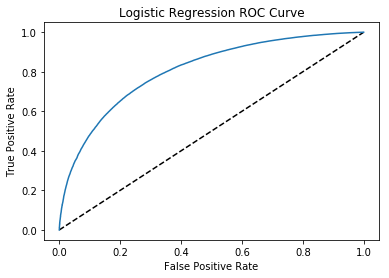

In [67]:
y_pred_prob = model.predict_proba(X_model_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_model_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression for CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

When predicting if borrowers are going to default or pay off their loans, there are two types of errors we could make.  We could predict a borrower is going to pay off their loan and then actually have them default or we could predict a borrower is going to default on their loan and then actually have them pay the loan off.  Borrowers who are predicted to pay off their loan but end up defauting would be more costly for the bank.  

With that in mind, we would want to error towards saying borrowers will default.  

If predicting borrowers that will default is our target, then we want a high True Positive rate and we can sacrifice on the False Positive rate.  

# How do I tell if I am predicting Default or Paid Off loans???